# Recurrent SLDS
A Recurrent Switching Linear Dynamical System (rSLDS) is a generalization of a Switching Linear Dynamical System (SLDS) in which the switches in the discrete state are allowed to depend on the value of the continuous state (hence the name recurrent). The rSLDS was developed by Linderman _et al_ in ["Bayesian Learning and Inference in Recurrent Switching Linear Dynamical Systems"](http://proceedings.mlr.press/v54/linderman17a.html).

In this notebook, we'll give an example of fitting an rSLDS from data, and show that it can learn globally non-linear dynamics. We will focus on using an rSLDS in the context of SSM, and so will skip most of the implementation-level details. For more information on implementation, see the paper above.


## 1. Generative model for rSLDS
The generative model for rSLDS is the same as the SLDS case, except that the discrete state transition probabilities are modulated by the continuous state.

1. **Discrete State Update**. At each time step, sample a new discrete state $z_t \mid z_{t-1}, x_{t-1}$ with probabilities driven by a logistic regression on the continuous state: 
$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( \log (P_{j,i}) + W_i^T u_t + R_i ^T x_{t-1} \right)}
$$
where $W_i$ is a vector of weights associated with discrete state $i$, that control dependence on an external, known input $u_t$. $R_i$ is again a vector of weights assocaited with state $i$, which weights the contribution from the prior state.

2. **Continuous State Update**. Update the state using the dynamics matrix corresponding to the new discrete state:
$$
x_t = A_k x_{t-1} + V_k u_{t} + b_k + w_t
$$
$A_k$ is the dynamics matrix corresponding to discrete state $k$. $u_t$ is the input vector (specified by the user, not inferred by SSM) and $V_k$ is the corresponding control matrix. The vector $b$ is an offset vector, which can drive the dynamics in a particular direction. 
The terms $w_t$ is a noise terms, which perturbs the dynamics. 
Most commonly these are modeled as zero-mean multivariate Gaussians,
but one nice feature of SSM is that it supports many distributions for these noise terms. See the Linear Dynamical Systems notebook for a list of supported dynamics models.

3. **Emission**. We now make an observation of the state, according to the specified observation model. In the general case, the state controlls the observation via a Generalized Linear Model:
$$
y_t \sim \mathcal{P}(\eta(C_k x_t + d_k + F_k u_t + v_t))
$$
$\mathcal{P}$ is a probabibility distribution. The inner arguments form an affine measurement of the state, which is then passed through the inverse link function $\eta(\cdot)$.
In this case, $C_k$ is the measurement matrix corresponding to discrete state $k$, $d_k$ is an offset or bias term corresponding to discrete state $k$, $F_k$ is called the feedthrough matrix or passthrough matrix (it passes the input directly to the emission). In the Gaussian case, the emission can simply be written as $y_t = C_k x_t + d_k + F_k u_t + v_t$ where $v_t$ is a Gaussian r.v. See the Linear Dynamical System notebook for a list of the observation models supported by SSM.
  






In [1]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"] # colors is defined in the global scope — earlier in the notebook or script.
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size])) #zcps (change-points) identifies where the discrete state changes in time
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2 # the function plot_most_likely_dynamics(...) is hardcoded to visualize 2D latent dynamics. It would crash or misbehave if D ≠ 2.
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1) # For each point in latent space, picks the most likely discrete state using the transition function (which depends on position in latent space via logistic regression).

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy # compute the flows at each point

        zk = z == k # zk is a mask that is True wherever z[i] == k. example -> zk = [False, True, True, False, False, False]. So it's used to select only the points in the latent grid that are most likely assigned to discrete state k.
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

/home/dariosannino/ssm/ssm_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Simulating Data from an rSLDS

Below, we create a simulated dataset from a non-linear system, which we'll call the "Nascar" dataset. The Nascar dataset is meant to emulate cars going around a track. There are 4 states total: 2 each for driving  along each straightaway, and two for semicircular turns at each end of the track.

You'll note that in creating the rSLDS we use **transitions="recurrent_only"**. This means that the transition probabilities are determined only by the previous state (and on the inputs, if present). There is no dependence on the prior $z_t$. Instead, each state simply has a constant bias $r_i$ which biases the transitions toward state $i$. This model is strictly less flexible that the full rSLDS formulation. **By setting the weights on the current state to be very large, we make the discrete state transitions essentially deterministic**. After creating the rSLDS and sampling a trajectory, we plot the true trajectory below.


In [2]:
# Global parameters
T = 10000
K = 4
D_obs = 10
D_latent = 2

In [3]:
# Simulate the "nascar" data
def make_nascar_model():
    As = [random_rotation(D_latent, np.pi/24.), # different rotation speeds
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space -> you're controlling how sharp or decisive the transitions are in each direction.
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4)) # shows the weights Ri that define how the continuous latent state x affects the transition probabilities into the discrete states.
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))
    
    true_rslds = ssm.SLDS(D_obs, K, D_latent, 
                      transitions="recurrent_only", # The probability of switching between discrete states depends only on the current latent state xt rather than involving the previous state z_{t-1}
                      dynamics="diagonal_gaussian", # each dimension evolves independently (diagonal covariance).
                      emissions="gaussian_orthog", # observations are linear projections from latent space + Gaussian noise.
                      single_subspace=True) # All discrete states share the same emission matrix C. So while the latent dynamics differ per state, the mapping to observed space is shared.
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1)) # This sets the same initial mean μinit=[0,1] for each discrete state.
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent)) # initial variance of the latent state for each discrete state. It is very low so the system becomes almost deterministic
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))
    
    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r
    
    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs)) # The log is just used because it's easier and safer to optimize in an unconstrained space. Reduced the variance from 1e-2 to 1e-4

    return true_rslds

# Sample from the model
true_rslds = make_nascar_model()
z, x, y = true_rslds.sample(T=T)

**Visualizing Trajectories**

We've defined some helper functions above to plot the latent state trajectories, and color code them according to the discrete state. In the left panel, we show the continuous state trajectories. In the right panel below, we show 3 of the observations over the first 1000 time steps (our observations are 10 dimensional, but we've plotted 3 observation traces to reduce clutter).

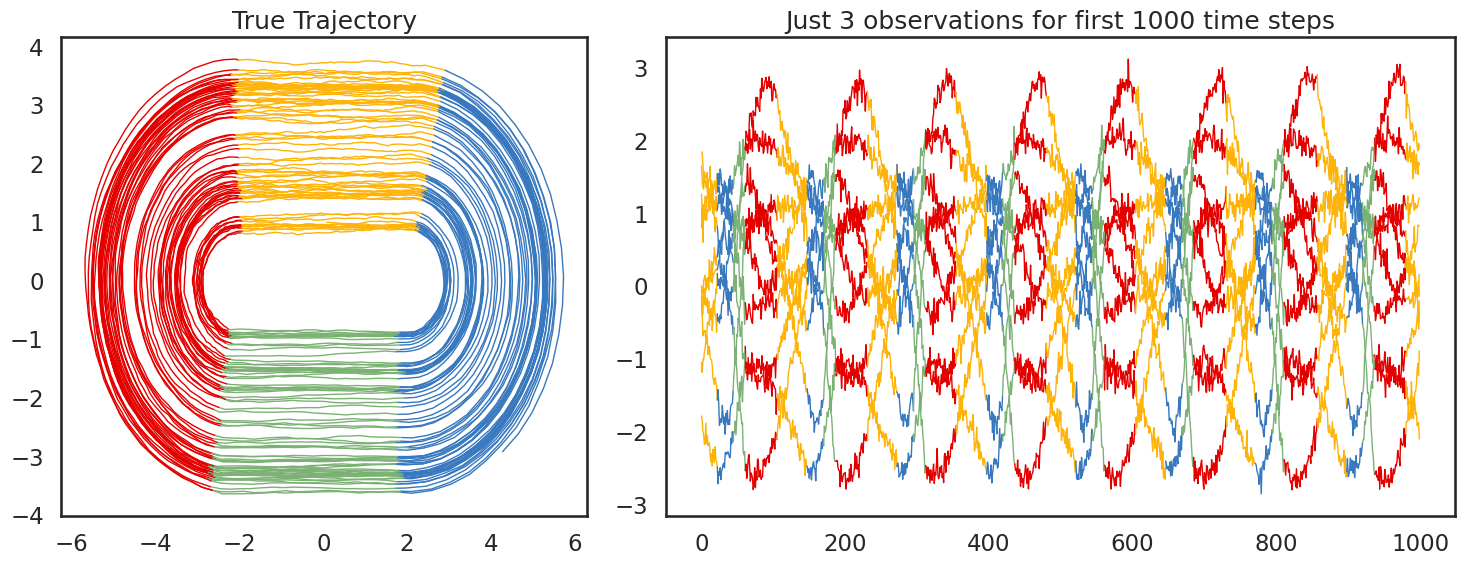

In [4]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(z, x, ax=ax0)
plt.title("True Trajectory")
# x1 = np.linspace(1, 3, 100)
# x2 = -10 * x1 + 20
# plt.plot(x1, x2, '--k', label="Boundary between state 0 and 3")

ax1 = plt.subplot(gs[1])
plot_observations(z[:1000], y[:1000,:], ax=ax1)
plt.title("Just 3 observations for first 1000 time steps")
plt.tight_layout()

I'll try to study the impact of a scaling factor in front of the $R_i$

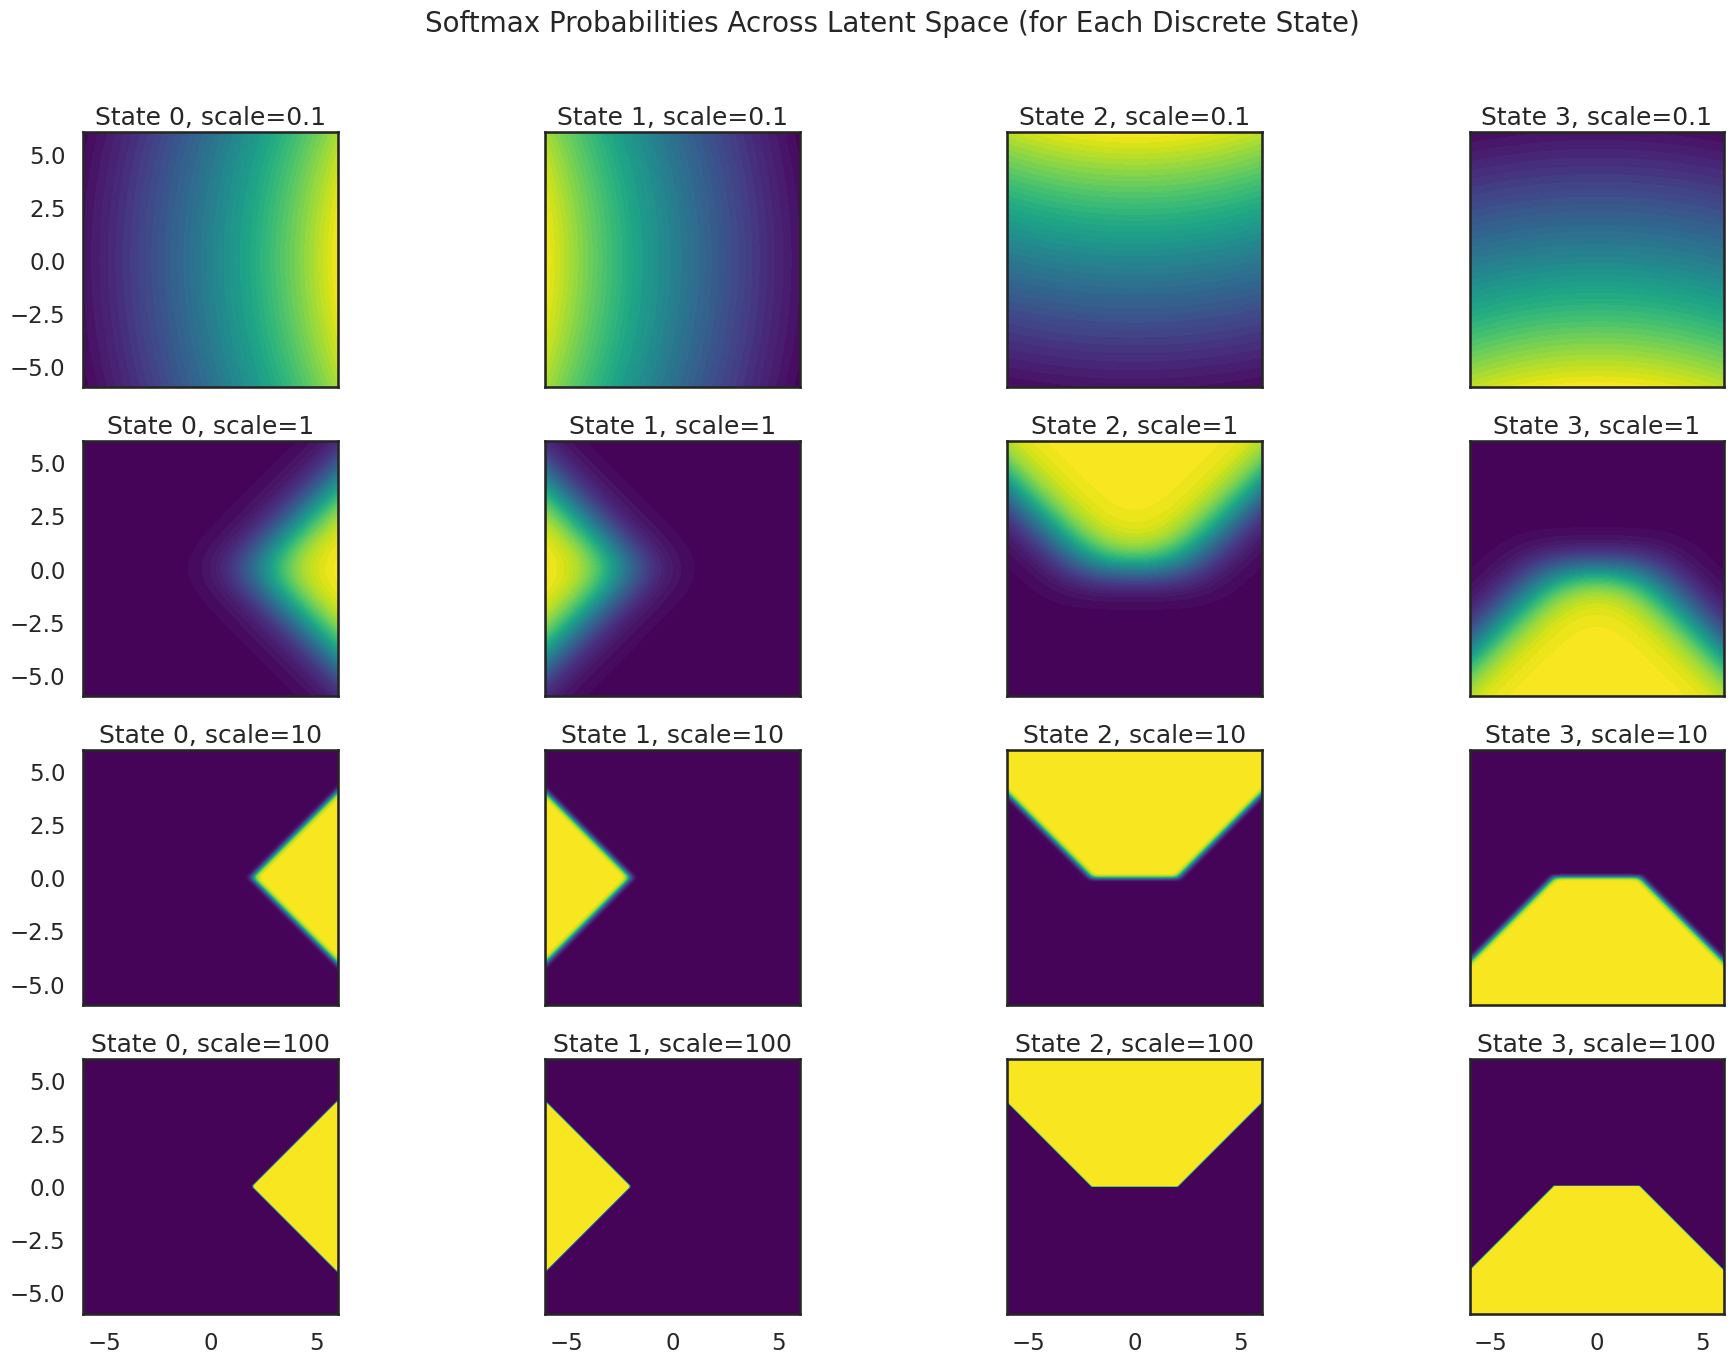

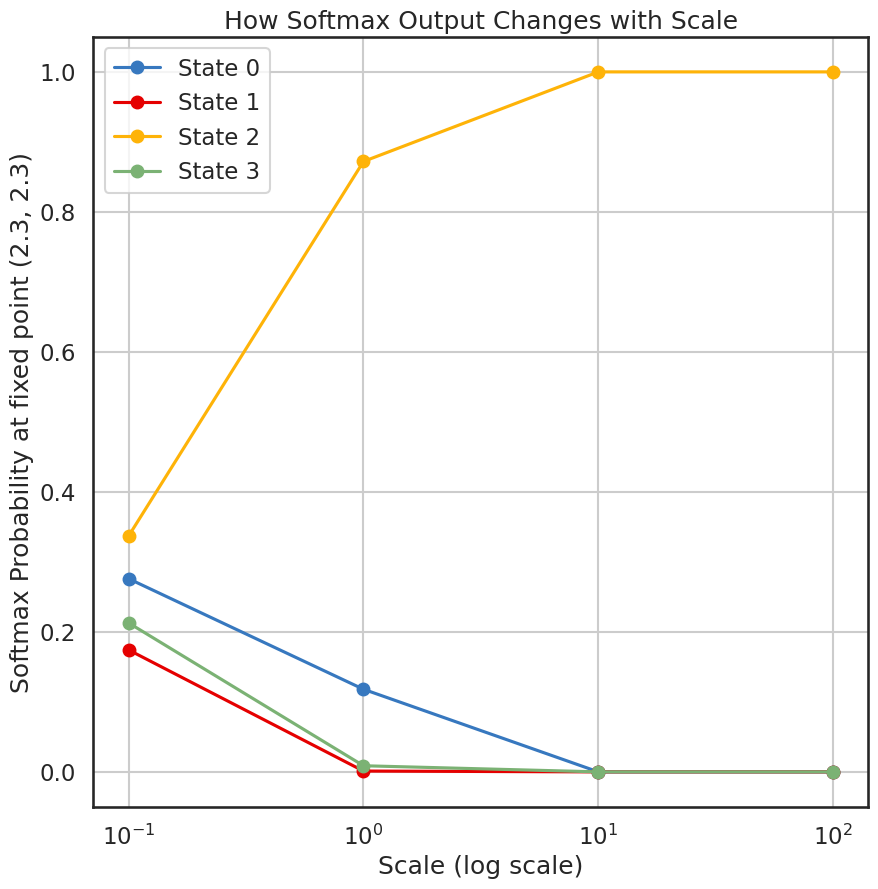

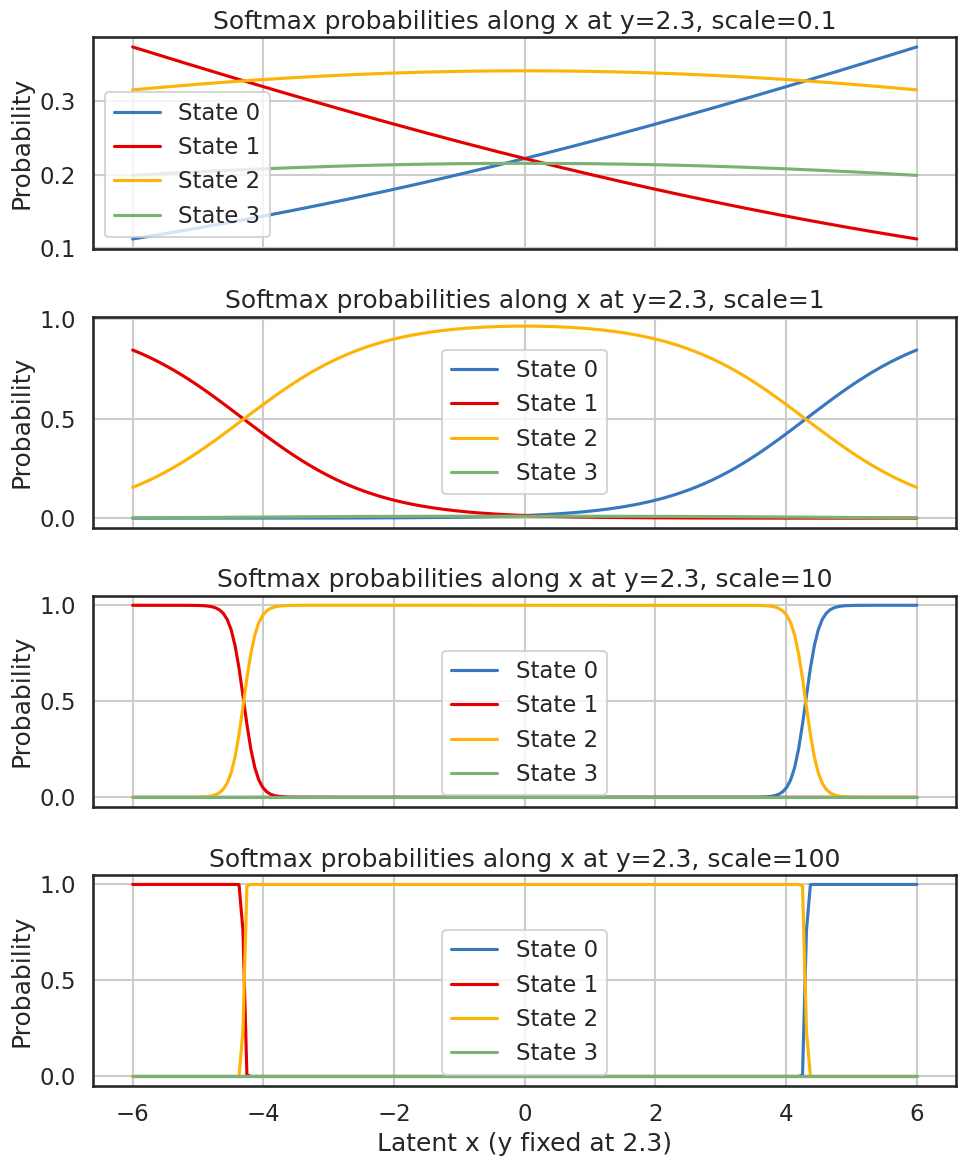

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up for visualization
sns.set_context("talk")
sns.set_style("white")

# Define a grid of x values in latent space
x_vals = np.linspace(-6, 6, 200)
y_vals = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(x_vals, y_vals)
grid_points = np.stack([X.ravel(), Y.ravel()], axis=-1)  # shape (num_points, 2)

# Define Rs and r for the 4 states (as in the NASCAR model)
w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x > -b
w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # x < b
w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0

W = np.vstack([w1, w2, w3, w4])
b = np.concatenate([b1, b2, b3, b4])

# Define scales to visualize softmax sharpness
scales = [0.1, 1, 10, 100]

path = np.stack([x_vals, 2.3 * np.ones_like(x_vals)], axis=1)  # move along x, fixed y

# Plot the actual softmax values (across states) at one fixed point as scale increases
fixed_point = np.array([[2.3, 2.3]])  # You can change this to any other point in latent space

softmax_curves = []
# Plot softmax probabilities for each state at different scales
fig, axes = plt.subplots(len(scales), 4, figsize=(20, 14), sharex=True, sharey=True)
for i, scale in enumerate(scales):
    logits = grid_points @ (scale * W).T + scale * b
    probs = np.exp(logits)
    probs /= np.sum(probs, axis=1, keepdims=True)

    logits_fp = fixed_point @ (scale * W).T + scale * b
    probs_fp = np.exp(logits_fp)
    probs_fp /= np.sum(probs_fp, axis=1, keepdims=True)
    softmax_curves.append(probs_fp[0])

    for k in range(4):  # 4 states
        ax = axes[i, k]
        prob_grid = probs[:, k].reshape(X.shape)
        contour = ax.contourf(X, Y, prob_grid, levels=50, cmap="viridis")
        ax.set_title(f"State {k}, scale={scale}")
        ax.set_aspect("equal")

fig.suptitle("Softmax Probabilities Across Latent Space (for Each Discrete State)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

x1, x2 = fixed_point[0]
# Plot how softmax output at a fixed point changes with scale
fig, ax = plt.subplots(figsize=(10, 10))
for k in range(4):
    ax.plot(scales, [curve[k] for curve in softmax_curves], marker='o', label=f"State {k}", color=colors[k])
ax.set_xscale("log")
ax.set_xlabel("Scale (log scale)")
ax.set_ylabel(f"Softmax Probability at fixed point ({x1}, {x2})")
ax.set_title("How Softmax Output Changes with Scale")
ax.grid(True)
ax.legend()
plt.show()

# Evaluate softmax along the path for different scales
fig, axes = plt.subplots(len(scales), 1, figsize=(10, 12), sharex=True)

for i, scale in enumerate(scales):
    logits = path @ (scale * W).T + scale * b
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    
    for k in range(4):
        axes[i].plot(x_vals, probs[:, k], label=f"State {k}", color=colors[k])
    
    axes[i].set_title(f"Softmax probabilities along x at y=2.3, scale={scale}")
    axes[i].set_ylabel("Probability")
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel("Latent x (y fixed at 2.3)")
plt.tight_layout()
plt.show()


## 3. Exercise

### 3.1 Linear vs. Non-Linear Systems
It's worth looking at the plot of the trajectories and considering the following: what behavior does the latent state show that could not be captured by a single linear dynamical system?

- Transitions between motion types (e.g., turning vs. going straight),

- State-dependent dynamics — i.e., the dynamics differ based on current location in latent space,

- Global nonlinearity, despite each local segment being linear.

### 3.2 Understanding the discrete state transitions
Let's look again at the form of the discrete state transition probabilities:

$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( \log (P_{j,i}) + w_i^T u_t + r_i ^T x_{t-1} \right)}
$$

In this case, we have used the **recurrent only** transitions class, which means we get rid of the transition matrix and replace it with a bias. Since we don't have any external inputs here, we can also leave out the input terms:


$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( r_i + R_i ^T x_{t-1} \right)}
$$

**What happens as the magnitude of the entries in $R_i$ become very large (compared to the entries of $R_j$ for the other states)? Do the transitions become more or less random?**

The dot product 
$R^{T}_{i}$ grows in magnitude → positive or negative depending on alignment.

This sharpens the softmax: the difference between logits becomes larger.

As a result, the softmax becomes more peaked → transitions become more deterministic.

In other words: \
Small $R_i$ → softmax logits close together → more random transitions (similar probabilities across states).

Large $R_i$ → one logit dominates → transition is more confident and state-dependent. 

## 4. Fitting an rSLDS
Below, we create a new rSLDS object and fit it to the data generated above (note that our new rSLDS will only have access to the observations $y$ and not the true states $z$ or $x$). 

### 4.1 Fitting Methods
The fitting methods available for the rSLDS are the same as those available for the SLDS. We've reproduced the section on fitting methods from the SLDS notebook below.

**Important Note:**  
 <span style="font-size:larger;">
Understanding the following section is not necessary to use SSM! _For practical purposes, it is almost always best to use the Laplace-EM method with the Structured Mean-Field Posterior, which is the default._ Running the below cells will be a bit slow on a typical laptop (around 5 minutes). We're working on speeding things up in future releases of SSM.
</span>

**Parameter Learning for rSLDS**  
Parameter learning in an rSLDS requires approximate methods. SSM provides two approximate inference algorithms: Black Box Variational Inference (`"bbvi"`) and Laplace Variational EM (`"laplace_em"`). We don't have the space to describe these methods in detail here, but Black Box Variational Inference was described in ["Variational Inference: A Review for Statisticians"](https://arxiv.org/pdf/1601.00670.pdf) by Blei et al. The Laplace Approximation is described in several sources, but a good reference for the context of state-space models is ["Estimating State and Parameters in state-space models of Spike Trains,"](https://pdfs.semanticscholar.org/a71e/bf112cabd47cc67284dc8c12ab7644195d60.pdf) a book chapter by Macke et al.  The specific method used in this notebook is described by ["Zoltowski et al (2020)"](https://arxiv.org/abs/2001.04571).



**Approximate Posterior Distributions**
When using approximate methods, we must choose the form of the distribution we use to approximate the posterior. Here, SSM provides three options:
1. `variational_posterior="meanfield"`
The mean-field approximation uses a factorized distribution as the approximating posterior. Compatible with the BBVI method.

2. `variational_posterior="tridiag"`
This approximates the posterior using a Gaussian with a block tridiagonal covariance matrix, which can be thought of as approximating the SLDS posterior with the posterior from an LDS. Compatible with the BBVI method.

3. `variational_posterior="structured_meanfield"`
This assumes a posterior where the join distribution over the continuous and discrete latent states factors as follows. If $q(z,x \mid y)$ is the joint posterior of the discrete and continuous states given the data, we use the approximation $q(z,x \mid y) \approx q(z \mid y)q(x \mid y)$, where $q(z \mid y)$ is the posterior for a Markov chain. Compatible with the Laplace-EM method.

**Calling the Fit function in SSM**  
All models in SSM share the same general syntax for fitting a model from data. Below, we call the fit function using three different methods and compare convergence. The syntax is as follows:
```python
elbos, posterior = slds.fit(data, method= "...",
                            variational_posterior="...",
                            num_iters= ...)
```
In the the call to `fit`, method should be one of {`"bbvi"`, `"laplace_em"`}.  
The `variational_posterior` argument should be one of {`"mf"`, `"structured_meanfield"`}. However, when using Laplace-EM _only_ structured mean field is supported.
Below, we fit using four methods, and compare convergence.


### 4.2 Getting the Inferred States
For every LDS, SLDS, and rSLDS model in SSM, calling `fit` returns a tuple of `(elbos, posterior)`.  `elbos` is a list containing a lower bound on the log-likelihood of the data at each iteration, used to check the convergence of the fitting algorithm. `posterior` is a posterior object (the exact type depends on which posterior is used). The posterior object is used to get an estimate of the latent variables (in this case $x$ and $z$) for each time step.

Below, we use the line:
```python
xhat_lem = q_lem.mean_continuous_states[0]
```

to get an estimate $\hat x$ of the continuous state over time. The reason for the index `[0]` is that `posterior.mean_continuous_states` will return a list, where each entry is the posterior for a given trial. In this case, we only have a single trial, so we get the first (and only) element of the list.


ELBO: 86568.2: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


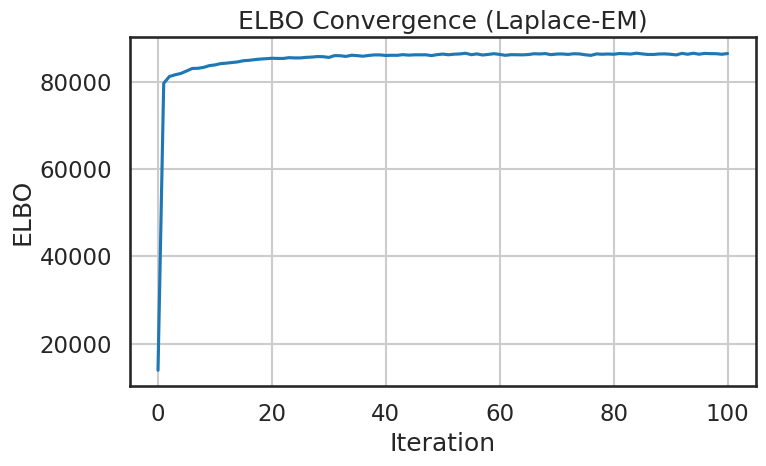

In [6]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)
q_elbos_lem, q_lem = rslds.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0] # gives the posterior means of all latent states x1,...,xt
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, y)))
zhat_lem = rslds.most_likely_states(xhat_lem, y) # Apply the Viterbi algorithm. It finds the most likely path through discrete states that explain the observations and the latent trajectory. This gives you the singòle best sequence of discrete states - not a distribution

# store rslds
rslds_lem = copy.deepcopy(rslds)

# Added by me

plt.figure(figsize=(8, 5))
plt.plot(q_elbos_lem)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Convergence (Laplace-EM)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
_, Ex, smoothed_sigmas, _ = q_lem.continuous_expectations[0] # Returns (log_Z, Ex, smoothed_sigmas, ExxnT)

smoothed_sigmas.shape 


(10000, 2, 2)

In [8]:
q_lem.mean_discrete_states[0]  # shape (T, K) Look at that if you want to look at uncertainties over discrete states


array([[2.50000000e-001, 2.50000000e-001, 2.50000000e-001,
        2.50000000e-001],
       [1.75238179e-050, 1.00000000e+000, 1.34621109e-080,
        1.18186823e-046],
       [2.29069977e-050, 1.00000000e+000, 5.33074588e-075,
        8.39744119e-044],
       ...,
       [1.67959193e-067, 1.46072854e-307, 2.20114392e-240,
        1.00000000e+000],
       [4.24216517e-065, 1.42165907e-318, 1.19882289e-225,
        1.00000000e+000],
       [1.12290889e-087, 3.40411230e-321, 8.71737439e-162,
        1.00000000e+000]], shape=(10000, 4))

In [9]:
xhat_lem

array([[-0.32003301, -0.7138555 ],
       [-0.30126704, -0.81469384],
       [-0.2791921 , -0.91867286],
       ...,
       [ 3.69505894, -4.97804588],
       [ 3.99824833, -4.59825581],
       [ 4.24996057, -4.18190293]], shape=(10000, 2))

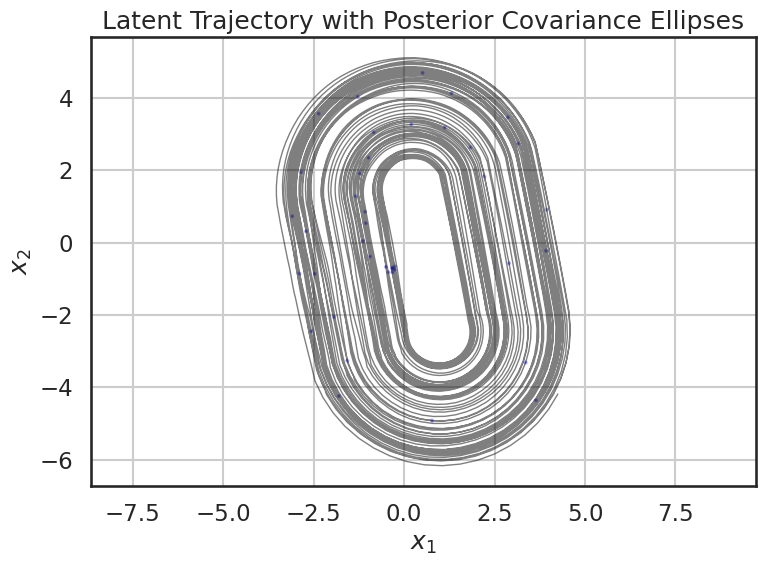

In [10]:
from matplotlib.patches import Ellipse

# Plot latent space with ellipses for uncertainty
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Ex[:, 0], Ex[:, 1], lw=1, color='black', alpha=0.5, label='Latent trajectory')

for t in range(0, T, 250):
    cov = smoothed_sigmas[t]
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(vals)
    ellipse = Ellipse(xy=Ex[t], width=width, height=height, angle=angle, alpha=0.3, color='blue')
    ax.add_patch(ellipse)

ax.set_title("Latent Trajectory with Posterior Covariance Ellipses")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.grid(True)
plt.tight_layout()

In [11]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)

q_elbos_bbvi, q_bbvi = rslds.fit(y, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=1000)

ELBO: 78544.0: 100%|██████████| 1000/1000 [00:41<00:00, 23.90it/s]


In [12]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_bbvi, y)))
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, y)

### 4.4 Checking Convergence
Below, we plot the ELBO obtained via both Laplace-EM and BBVI. We see that the Laplace-EM algorithm tends to converge must faster (and to a better lower bound).

Text(0, 0.5, 'ELBO')

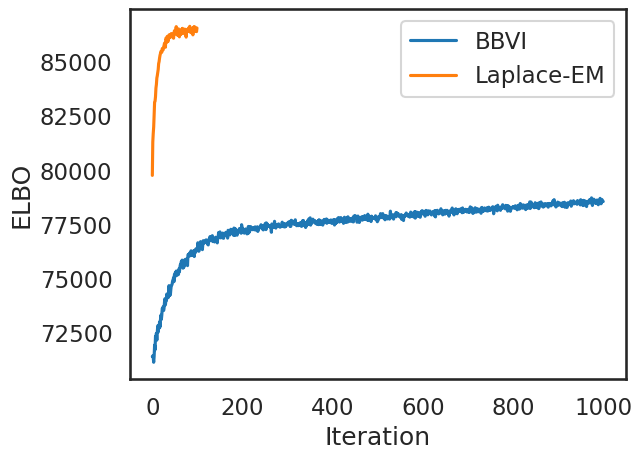

In [13]:
# Plot some results
plt.figure()
plt.plot(q_elbos_bbvi, label="BBVI")
plt.plot(q_elbos_lem[1:], label="Laplace-EM")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("ELBO")

## 5. Visualizing True and Inferred States
We wrote some helper functions above that plot a state trajectory, with different colors corresponding to the discrete latent states. **Note**: we only can recover the true system up to an affine transformation. That's why, even though we have permuted the discrete states to match the true system, the colors don't always match up.

In the cell immediately below, we see that the estimated latent trajectories found using Laplace-EM match the ground-truth more closely. In the cell below that, we extract the dynamics matrices the $A_k$s and use them to plot the system dynamics in each state. Note that the Laplace-EM algorithm does a better job at finding the positions in state-space which trigger discrete state transitions. 

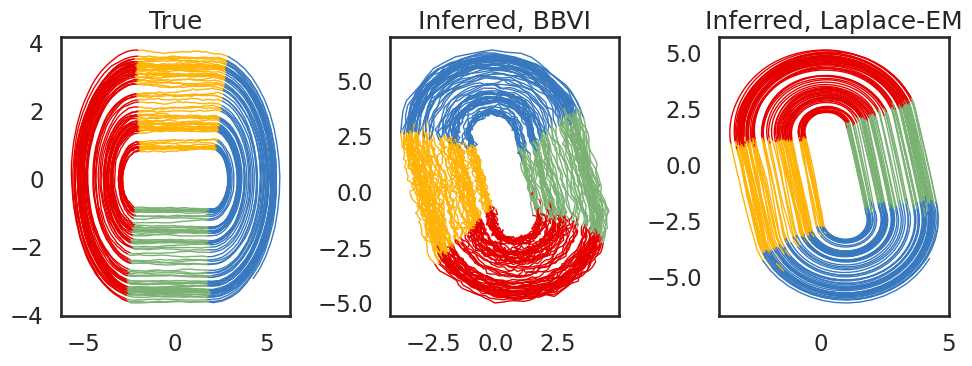

In [14]:
plt.figure(figsize=[10,4])
ax1 = plt.subplot(131)
plot_trajectory(z, x, ax=ax1)
plt.title("True")
ax2 = plt.subplot(132)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax2)
plt.title("Inferred, BBVI")
ax3 = plt.subplot(133)
plot_trajectory(zhat_lem, xhat_lem, ax=ax3)
plt.title("Inferred, Laplace-EM")
plt.tight_layout()

Text(0.5, 1.0, 'Inferred Dynamics, BBVI')

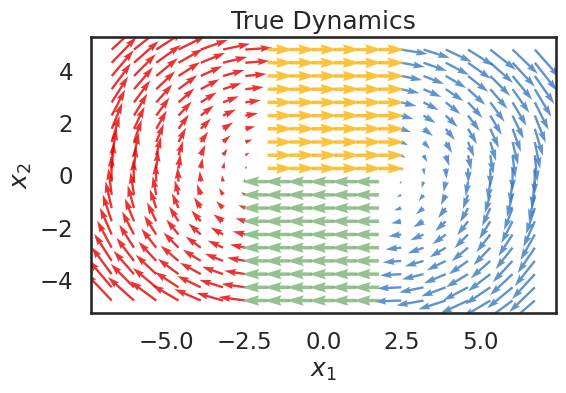

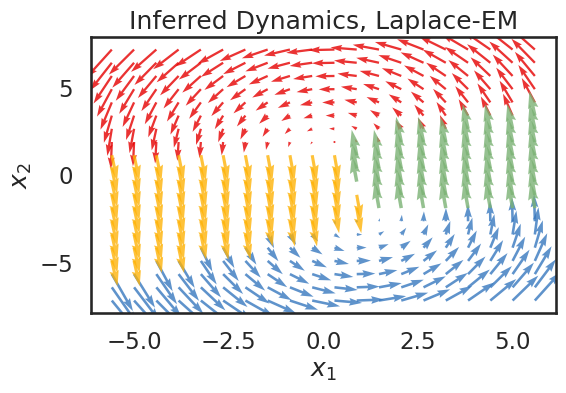

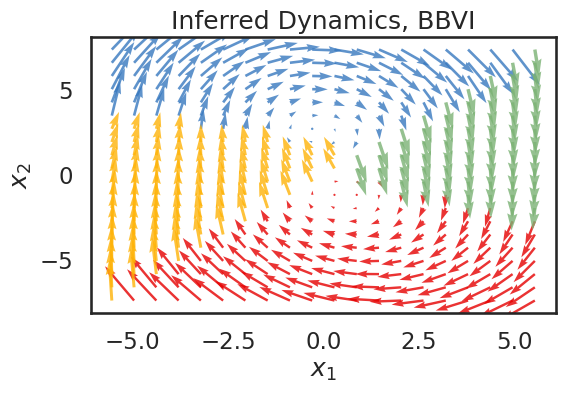

In [15]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(x).max(axis=0) + 1
plot_most_likely_dynamics(true_rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("True Dynamics")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_bbvi).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, BBVI")

In [50]:
rslds_lem.dynamics.sample_x


<bound method AutoRegressiveObservations.sample_x of <ssm.observations.AutoRegressiveDiagonalNoiseObservations object at 0x753df2bd8470>>

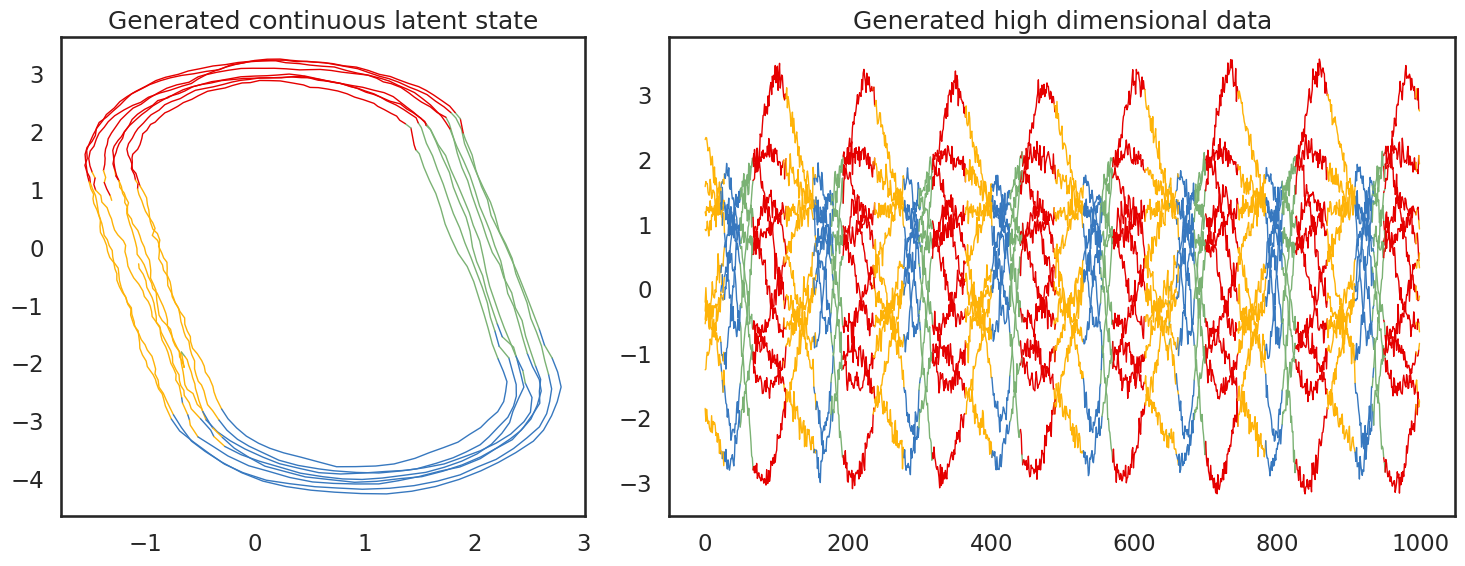

In [45]:
# Generate a new sample from the model
T_new = 1000  # or however long you want
z_gen, x_gen, y_gen = rslds_lem.sample(T_new, with_noise=True)

fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(z_gen, x_gen, ax=ax0)
plt.title("Generated continuous latent state")

ax1 = plt.subplot(gs[1])
plot_observations(z_gen, y_gen, ax=ax1)
plt.title("Generated high dimensional data")
plt.tight_layout()